In [50]:
from scipy.stats import norm
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os

sys.path.append('/home/kmb/.local/lib/python3.6/site-packages')  
import nibabel as nib
from behavioral_models import load_behavioral_data                           #TODO: create modulel
from nilearn import plotting
from nistats.second_level_model import SecondLevelModel

In [28]:
# Load metadata
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
_, meta = load_behavioral_data(root=beh_dir, verbose=False)
n_subjects, n_conditions = len(meta['dim1']), len(meta['dim2'])

# Load t-map images
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/buttonpress"

tmap_files = [sorted([os.path.join(out_dir, file) 
              for file in os.listdir(out_dir) if task in file]) 
              for task in ['prlrew', 'prlpun']]

tmap_img = [[None] * n_subjects] * n_conditions
for sub_idx in range(n_subjects):
    for con_idx in range(n_conditions):
        tmap_img[con_idx][sub_idx] = nib.load(tmap_files[con_idx][sub_idx])

/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


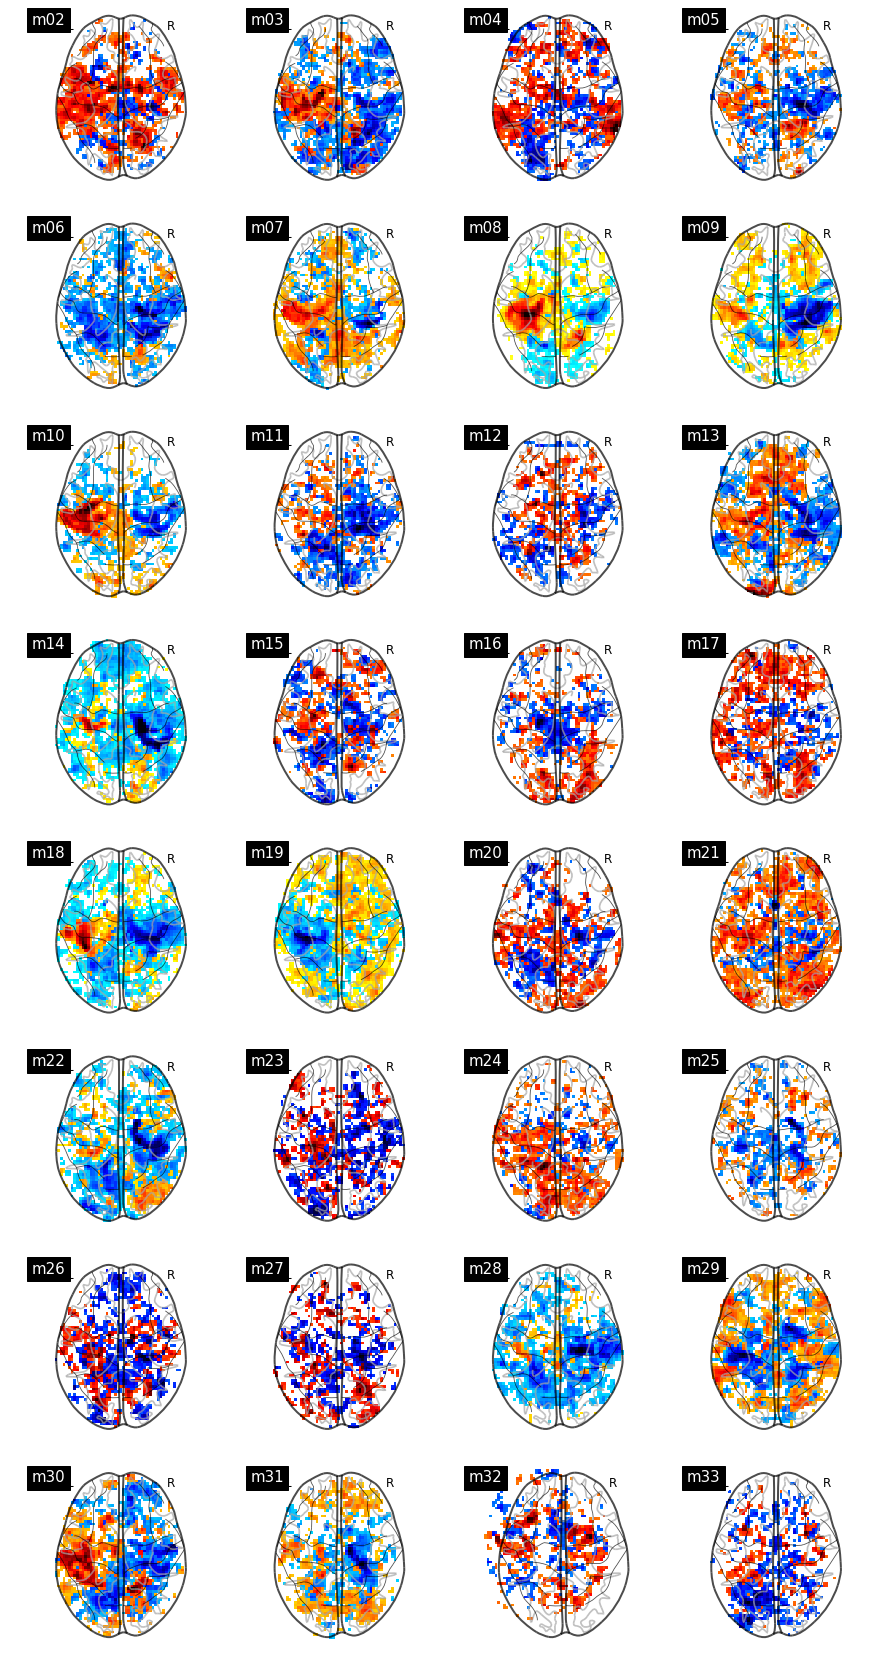

In [41]:
fig, ax = plt.subplots(
    nrows=8, ncols=4, 
    facecolor='w', figsize=(15, 30))

for cidx, tmap in enumerate(tmap_img[1]):
    plotting.plot_glass_brain(
        tmap, 
        colorbar=False, 
        threshold=2.0,
        title=meta['dim1'][cidx],
        axes=ax[int(cidx / 4)][int(cidx % 4)],
        plot_abs=False,
        display_mode='z')
    

In [47]:
second_level_input = [tmap for tmaps in tmap_img for tmap in tmaps]

design_matrix = pd.DataFrame([1] * len(second_level_input),
                             columns=['intercept'])

second_level_model = SecondLevelModel(smoothing_fwhm=8)
second_level_model = second_level_model.fit(
    second_level_input, 
    design_matrix=design_matrix)

z_map = second_level_model.compute_contrast(output_type='z_score')

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [83]:
mni152nlin2009c = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code/first_level_analysis/mni_icbm152_nlin_asym_09c_nifti/mni_icbm152_nlin_asym_09c/mni_icbm152_t1_tal_nlin_asym_09c.nii"
bg_img = nib.load(mni152nlin2009c)

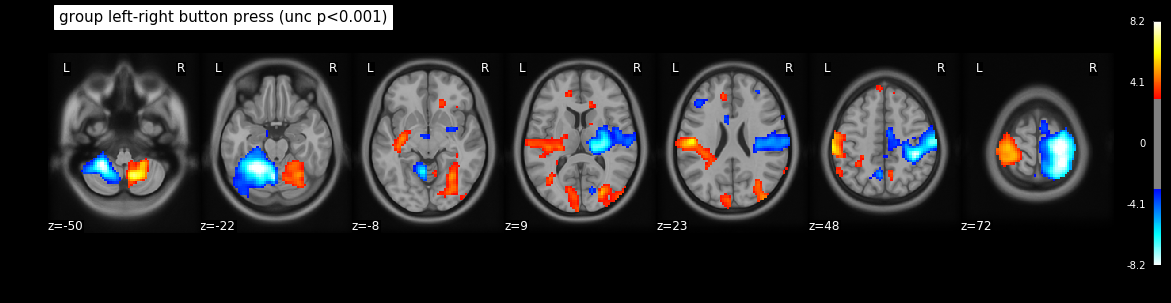

In [88]:
p_val = 0.001
fig, ax = plt.subplots(ncols=1, nrows=1, facecolor='k', figsize=(20, 5))
display = plotting.plot_stat_map(
    z_map,
    bg_img=bg_img,
    axes=ax,
    threshold=norm.isf(p_val),
    colorbar=True,
    display_mode='z',
    title='group left-right button press (unc p<0.001)')

In [80]:
from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

pial_right = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/derivatives/freesurfer/fsaverage/surf/rh.pial"
infl_right = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/derivatives/freesurfer/fsaverage/surf/rh.inflated"
sulc_right = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study/derivatives/freesurfer/fsaverage/surf/rh.sulc"

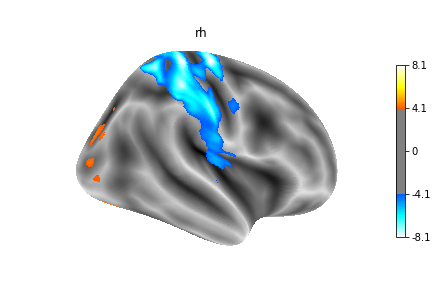

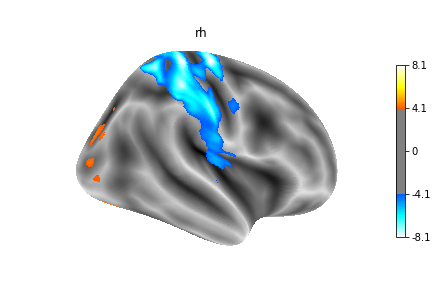

In [81]:
texture = surface.vol_to_surf(z_map, pial_right)

plotting.plot_surf_stat_map(
    infl_right,
    texture,
    hemi='right', 
    title='rh', 
    colorbar=True, 
    threshold=4,
    bg_map=sulc_right)